In [ ]:
#Para manipulação de dados
import pandas as pd
import numpy as np
from datetime import datetime

#Para manipulação de arquivos
import zipfile
import json

#Para visualização
import matplotlib.pyplot as plt
import seaborn as sn
import folium
from folium.plugins import HeatMap

%matplotlib inline

In [ ]:
#Fornecendo permissão ao drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importando e lendo o dataset
path = '/content/drive/MyDrive/data_taxi/train.csv.zip'
z = zipfile.ZipFile(path)
train_df = pd.read_csv(z.open('train.csv'), index_col = False)
train_df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [ ]:
# Visualização rápida da base
#Descobrindo o formato dos dados
train_df.info()
train_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


TRIP_ID               0
CALL_TYPE             0
ORIGIN_CALL     1345900
ORIGIN_STAND     904091
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

In [ ]:
# Lendo e convertendo o arquivo Geojson em Geodataframe
'''
sf_path = '/content/drive/MyDrive/data_taxi/porto.json'
sf = gpd.read_file(sf_path, encoding='utf-8')
mapa_shape = sf.to_crs({'init': 'epsg:4326'})
mapa_shape
'''

"\nsf_path = '/content/drive/MyDrive/data_taxi/porto.json'\nsf = gpd.read_file(sf_path, encoding='utf-8')\nmapa_shape = sf.to_crs({'init': 'epsg:4326'})\nmapa_shape\n"

In [ ]:
# Formatando a data de UNIX para datetime
train_df['DC'] = [datetime.utcfromtimestamp(i) for i in train_df['TIMESTAMP']]

#Separando os valores das datas em novas colunas
train_df['Ano'] = train_df['DC'].dt.year
train_df['Mes'] = train_df['DC'].dt.month
train_df['Dia'] = train_df['DC'].dt.day
train_df['Hora'] = train_df['DC'].dt.hour
train_df['Minuto'] = train_df['DC'].dt.minute
train_df['Dia'] = train_df['DC'].dt.second


In [ ]:
#Retirando valores duplicados de Trip ID
train_df['TRIP_ID'].value_counts()
train_df = train_df.drop_duplicates(subset=['TRIP_ID'], keep='first')
train_df['TRIP_ID'].value_counts()

1384683034620000186    1
1400171431620000463    1
1374075962620000361    1
1388778783620000039    1
1389820270620000263    1
                      ..
1397476421620000468    1
1397278730620000534    1
1374055651620000247    1
1394648368620000633    1
1403071175620000484    1
Name: TRIP_ID, Length: 1710589, dtype: int64

In [ ]:
#Observação sobre Day type
train_df['DAY_TYPE'].value_counts()

A    1710589
Name: DAY_TYPE, dtype: int64

In [ ]:
#Formatando a string da Polyline
#Baseado no modelo do usuário raymonmina da plataforma Kaggle, notebook: "Notebook0f2646ced6"
def extract_data(x):
    splitted = x[2:-2].split('],[')      
    n_15 = len(splitted)
    if len(splitted) > 0 and len(splitted[0].split(',')) > 1 :
        lon,lat = splitted[0].split(',')
        return [lon, lat, n_15]
    else :
        return '0'

train_df['lo_lat']= train_df['POLYLINE'].apply(extract_data)
train_df = train_df[train_df.lo_lat != '0']
train_df['longitude'] = train_df['lo_lat'].apply(lambda x: float(x[0]) if len(x) > 0 else NULL)
train_df['latitude'] = train_df['lo_lat'].apply(lambda x: float(x[1]) if len(x) > 0 else NULL)
train_df['n_15'] = train_df['lo_lat'].apply(lambda x: x[2])
train_df.tail()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,DC,Ano,Mes,Dia,Hora,Minuto,lo_lat,longitude,latitude,n_15
1710663,1388660427620000585,C,NaN,NaN,20000585,1388660427,A,False,"[[-8.60697,41.162283],[-8.60697,41.16231],[-8....",2014-01-02 11:00:27,2014,1,27,11,0,"[-8.60697, 41.162283, 194]",-8.606970,41.162283,194
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-...",2014-06-30 23:37:43,2014,6,43,23,37,"[-8.612469, 41.14602, 32]",-8.612469,41.146020,32
1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[...",2014-06-30 23:36:07,2014,6,7,23,36,"[-8.610138, 41.140845, 30]",-8.610138,41.140845,30
1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-...",2014-06-30 15:23:46,2014,6,46,15,23,"[-8.630712, 41.154885, 62]",-8.630712,41.154885,62
1710669,1404157147620000079,B,NaN,34.0,20000079,1404157147,A,False,"[[-8.615538,41.140629],[-8.615421,41.140746],[...",2014-06-30 19:39:07,2014,6,7,19,39,"[-8.615538, 41.140629, 27]",-8.615538,41.140629,27


In [ ]:
# Preparando os dados de latitude/longitude para inserir no mapa
dest_df = train_df[['latitude', 'longitude','TAXI_ID']].copy()
dest_df.tail()

,latitude,longitude,TAXI_ID
1710663,41.162283,-8.606970,20000585
1710665,41.146020,-8.612469,20000698
1710666,41.140845,-8.610138,20000670
1710668,41.154885,-8.630712,20000248
1710669,41.140629,-8.615538,20000079


In [ ]:
# Mapa da região de Porto
mapa = folium.Map(location=[41.149472, -8.610778], zoom_start=4)

#Conversão dos dados para o mapa da região
dest_fo = dest_df[['latitude','longitude']].values.tolist()
HeatMap(dest_fo,radius = 20).add_to(mapa)


In [ ]:
#Visualização do mapa
mapa.save('mapa.html')

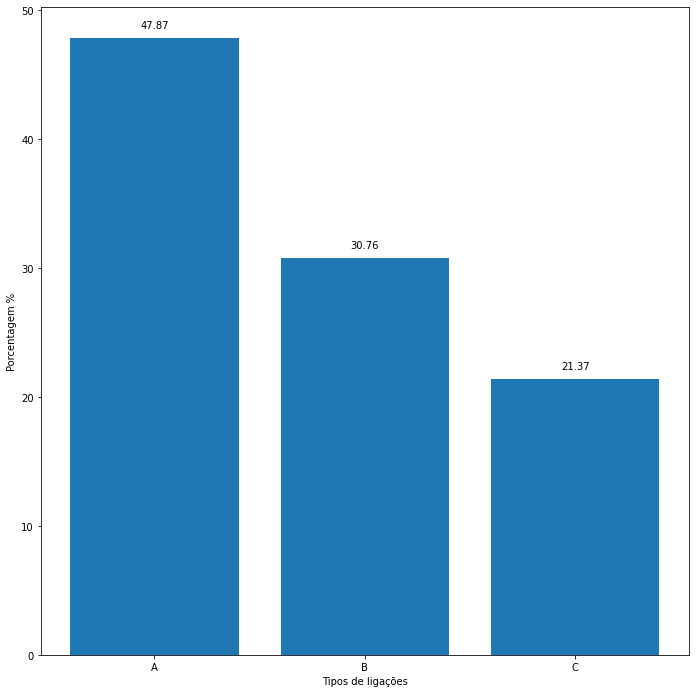

In [ ]:
#Outras visualizações

#Tipos de Ligação ('CALL_TYPE' no dataset de treinamento)
call = train_df.groupby('DAY_TYPE')['CALL_TYPE']
call_p = pd.concat([call.value_counts(), call.value_counts(normalize=True).mul(100)],axis=1, keys=('Contagem','Porcentagem'))
#Visualização por box chart

x = ['A','B','C']
perc = call_p['Porcentagem']
#graf1 = plt.bar(x,perc, color = 'green', label = 'Porcentagem')
fig_1 = plt.figure(figsize=(9,9))
axes_1 = fig_1.add_axes([0,0,1,1])
axes_1.set_xlabel('Tipos de ligações')
axes_1.set_ylabel('Porcentagem %')
plt.bar(x,perc)
# zip joins x and y coordinates in pairs
for x,y in zip(x,perc):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

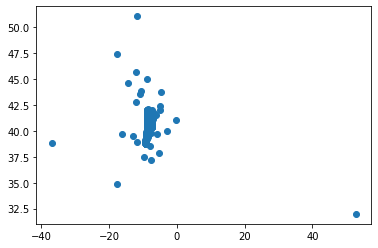

In [ ]:
#Visualizando origin_call em relação à data
plt.scatter(train_df['longitude'],train_df['latitude'])

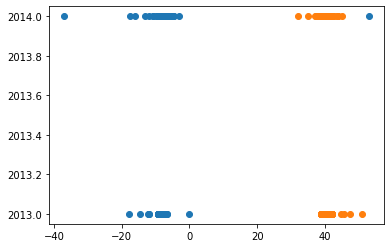

In [ ]:
plt.scatter(train_df['longitude'],train_df['Ano'])
plt.scatter(train_df['latitude'],train_df['Ano'])

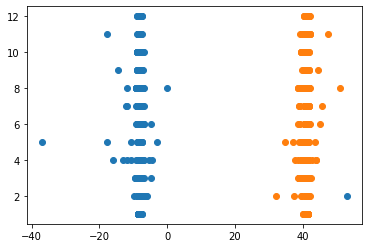

In [ ]:
plt.scatter(train_df['longitude'],train_df['Mes'])
plt.scatter(train_df['latitude'],train_df['Mes'])
